In [1]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"

### image show funcitons

In [2]:
def show_img(image):
    img = image.detach().cpu()
    img = img.squeeze(0)
    img = torch.clamp(img, 0, 1)
    plt.imshow(img.permute(1, 2, 0))
    
def final_show(image):
    img = image.detach().cpu()
    img = img.squeeze(0)
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(-1,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(-1,1,1)
    img = torch.clamp(img, 0, 1)
    plt.figure(figsize=(8,8))
    plt.imshow(img.permute(1, 2, 0))
    plt.axis('off')

def reverse_norm(image):
    img = image.detach().cpu()
    img = img.squeeze(0)
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(-1,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(-1,1,1)
    #img = img * torch.tensor([1, 1, 1]).view(-1,1,1) + torch.tensor([0.40760392, 0.45795686, 0.48501961]).view(-1,1,1)
    img = torch.clamp(img, 0, 1)
    img = img.permute(1, 2, 0)
    return img

def final_compare_show(content_img, style_img, combine_img):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
    ax1.imshow(reverse_norm(content_img))
    ax1.set_title('content image')
    ax1.set_axis_off()
    
    ax2.imshow(reverse_norm(style_img))
    ax2.set_title('style image')
    ax2.set_axis_off()
    
    ax3.imshow(reverse_norm(combine_img))
    ax3.set_title('transfer image')
    ax3.set_axis_off()
    

### content loss and style loss

In [3]:
def nst_loss(content_features, style_features, combine_features, content_layers, style_layers, style_weights):
    
    content_loss, style_loss = 0, 0
    for layer in content_layers:
        #content_loss += torch.sum((combine_features[layer] - content_features[layer])**2) / 2
        #content_loss += torch.mean((combine_features[layer] - content_features[layer])**2) ### find the use 'mean' is easy for tuning parameters here
        content_loss += F.mse_loss(combine_features[layer], content_features[layer])
        
    for idx, layer in enumerate(style_layers):
        style_b, style_c, style_h, style_w = style_features[layer].shape
        combine_b, combine_c, combine_h, combine_w = combine_features[layer].shape
        assert style_b * style_c == combine_b * combine_c
        assert style_h * style_w == combine_h * combine_w
        
        style_feature = style_features[layer].view(style_b * style_c, style_h * style_w)
        combine_feature = combine_features[layer].view(combine_b * combine_c, combine_h * combine_w)
        
        style_gram = torch.mm(style_feature, style_feature.t())
        combine_gram = torch.mm(combine_feature, combine_feature.t())
        style_loss += style_weights[idx] * torch.sum((combine_gram-style_gram) ** 2) / (4 * ((style_b*style_c)**2) * ((style_h*style_w)**2))
        
    return content_loss, style_loss

### Image Loader

In [4]:
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    
    std=[0.229, 0.224, 0.225]
)

def image_loader(image):
    transformer = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        normalize
    ])
    return transformer(image).unsqueeze(0)

### extract content, style features

In [5]:
layers_name = {0:'conv1_1', 2:'conv1_2', 
               5:'conv2_1', 7:'conv2_2', 
               10:'conv3_1', 12:'conv3_2', 14:'conv3_3', 16:'conv3_4', 
               19:'conv4_1', 21:'conv4_2', 23:'conv4_3', 25:'conv4_4',
               28:'conv5_1', 30:'conv5_2', 32:'conv5_3', 34:'conv5_4'}

In [6]:
def get_features(name, features):
    def hook(model, input, output):
        features[name] = output
        return output
    return hook

In [7]:
def content_style_features(layers_name, style_img, content_img, features):
    model = models.vgg19(pretrained=True)
    
    for idx, layer in enumerate(model.features):
        if idx in layers_name.keys():
            layer.register_forward_hook(get_features(layers_name[idx], features))
        
    model.cuda()
    model.eval()

    model(style_img)
    style_features = {}
    for key, value in features.items():
        style_features[key] = value.detach()
    model(content_img)
    content_features = {}
    for key, value in features.items():
        content_features[key] = value.detach()
        
    return model, content_features, style_features

### style transfer train

In [8]:
def style_transfer_train(model, features, combine_img,
                         cotent_features, style_features, conctent_layers, style_layers, 
                         learning_rate, max_epoch, alpha, beta, style_weight):
    
    combine_img.requires_grad = True

    optimizer = torch.optim.Adam([combine_img], lr=learning_rate)

    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, max_epoch)

    for ep in range(max_epoch):
    
        model(combine_img)
        combine_features = features.copy()
        
        content_loss, style_loss = nst_loss(content_features, style_features, combine_features, content_layers, style_layers, style_weight)
        total_loss = alpha * content_loss + beta * style_loss
       
        optimizer.zero_grad()
        total_loss.backward()
        if ep % 100 == 0:
            print('EP %d; Total Loss: %.5f; Content Loss: %.5f; Style Loss: %.5f' % 
                  (ep, total_loss, alpha * content_loss, beta * style_loss))
    
        optimizer.step()
    
    return combine_img

In [9]:
def LBFGS_style_transfer_train(model, features, combine_img,
                         cotent_features, style_features, conctent_layers, style_layers, 
                         learning_rate, max_epoch, alpha, beta, style_weight):
    
    combine_img.requires_grad = True

    optimizer = torch.optim.LBFGS([combine_img]);
    ep=[0]
    
    while ep[0] <= max_epoch:

        def closure():
            model(combine_img)
            combine_features = features.copy()
        
            content_loss, style_loss = nst_loss(content_features, style_features, combine_features, content_layers, style_layers, style_weight)
            total_loss = alpha * content_loss + beta * style_loss
       
            optimizer.zero_grad()
            total_loss.backward()
            
            ep[0]+=1

            if ep[0]%1000 == 999:
                print('Iteration: %d, loss: %f'%(ep[0]+1, total_loss.item()))

            return total_loss

        optimizer.step(closure)
    
    return combine_img

## Experiments

#### starry_night

In [10]:
style_image = Image.open('./style/starry_night.jpeg')
#content_image = Image.open('./content/duke_chapel.jpg')
content_image = Image.open('./content/new_content.jpeg')

style_img = image_loader(style_image).cuda()
content_img = image_loader(content_image).cuda()
features = {}

model, content_features, style_features = content_style_features(layers_name, style_img, content_img, features)

Iteration: 1000, loss: 55020.128906
Iteration: 2000, loss: 47374.417969
Iteration: 3000, loss: 44765.515625
Iteration: 4000, loss: 43556.320312
Iteration: 5000, loss: 42893.570312
Iteration: 6000, loss: 42472.878906
Iteration: 7000, loss: 42182.898438
Iteration: 8000, loss: 41965.363281
Iteration: 9000, loss: 41792.921875
Iteration: 10000, loss: 41654.671875


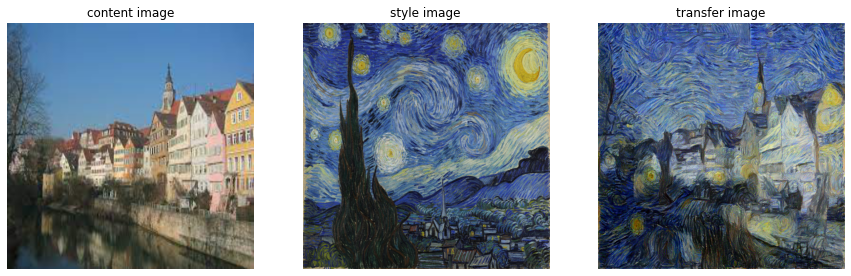

In [31]:
combine_img = image_loader(content_image).cuda()
content_layers = ['conv4_2',]
style_layers = ['conv1_1', 
                'conv2_1', 
                'conv3_1', 
                'conv4_1',
                'conv5_1',]

learning_rate = 0.05
max_epoch = 10000
alpha = 1
beta = 100000000
style_weight = [0.2,0.2,0.2,0.2,0.2]

combine_img = LBFGS_style_transfer_train(model, features, combine_img,
                    content_features, style_features, content_layers, style_layers, 
                    learning_rate, max_epoch, alpha, beta, style_weight)
final_compare_show(content_img, style_img, combine_img)

Iteration: 1000, loss: 55020.128906
Iteration: 2000, loss: 47374.417969
Iteration: 3000, loss: 44765.515625


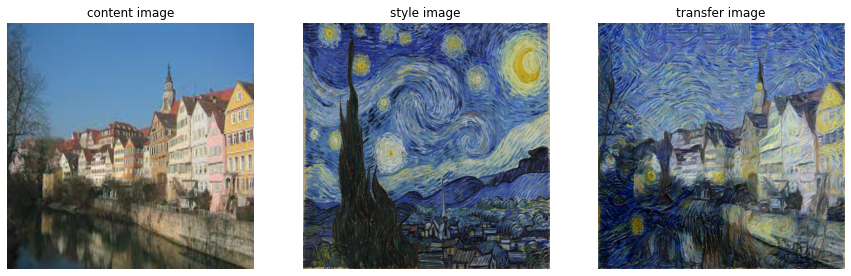

In [11]:
combine_img = image_loader(content_image).cuda()
content_layers = ['conv4_2',]
style_layers = ['conv1_1', 
                'conv2_1', 
                'conv3_1', 
                'conv4_1',
                'conv5_1',]

learning_rate = 0.05
max_epoch = 3000
alpha = 1
beta = 100000000
style_weight = [0.2,0.2,0.2,0.2,0.2]

combine_img = LBFGS_style_transfer_train(model, features, combine_img,
                    content_features, style_features, content_layers, style_layers, 
                    learning_rate, max_epoch, alpha, beta, style_weight)
final_compare_show(content_img, style_img, combine_img)

Iteration: 1000, loss: 5.628103
Iteration: 2000, loss: 5.267620
Iteration: 3000, loss: 5.198722
Iteration: 4000, loss: 5.166152
Iteration: 5000, loss: 5.147016
Iteration: 6000, loss: 5.133884
Iteration: 7000, loss: 5.123780
Iteration: 8000, loss: 5.116107
Iteration: 9000, loss: 5.110082
Iteration: 10000, loss: 5.104810


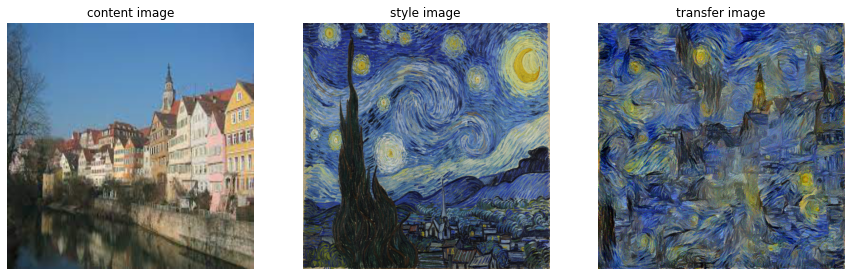

In [35]:
combine_img = torch.rand(content_img.shape).cuda()
content_layers = ['conv4_2',]
style_layers = ['conv1_1', 
                'conv1_2', 
                'conv2_1', 
                'conv3_1',
                'conv4_1',]

max_epoch = 10000
alpha = 1
beta = 1000
style_weight = [0.2,0.2,0.2,0.2,0.2]

combine_img = LBFGS_style_transfer_train(model, features, combine_img,
                    content_features, style_features, content_layers, style_layers, 
                    learning_rate, max_epoch, alpha, beta, style_weight)
final_compare_show(content_img, style_img, combine_img)

#### Composition

In [12]:
style_image = Image.open('./style/Composition.jpeg')
content_image = Image.open('./content/new_content.jpeg')
style_img = image_loader(style_image).cuda()
content_img = image_loader(content_image).cuda()
features = {}

model, content_features, style_features = content_style_features(layers_name, style_img, content_img, features)

Iteration: 1000, loss: 103943.781250
Iteration: 2000, loss: 90404.023438
Iteration: 3000, loss: 86613.476562
Iteration: 4000, loss: 84900.789062
Iteration: 5000, loss: 83908.382812
Iteration: 6000, loss: 83252.437500
Iteration: 7000, loss: 82785.601562
Iteration: 8000, loss: 82423.101562
Iteration: 9000, loss: 82121.765625
Iteration: 10000, loss: 81863.960938


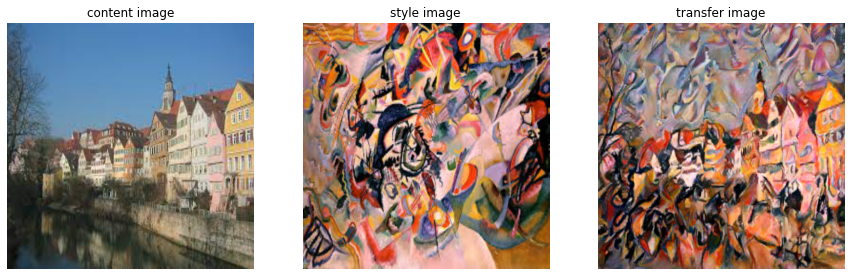

In [13]:
combine_img = image_loader(content_image).cuda()
content_layers = ['conv4_2',]
style_layers = ['conv1_1', 
                'conv2_1', 
                'conv3_1', 
                'conv4_1',
                'conv5_1',]

learning_rate = 0.05
max_epoch = 10000
alpha = 1
beta = 100000000
style_weight = [0.2,0.2,0.2,0.2,0.2]

combine_img = LBFGS_style_transfer_train(model, features, combine_img,
                    content_features, style_features, content_layers, style_layers, 
                    learning_rate, max_epoch, alpha, beta, style_weight)
final_compare_show(content_img, style_img, combine_img)

Iteration: 1000, loss: 80252.531250
Iteration: 2000, loss: 62837.375000
Iteration: 3000, loss: 58035.718750


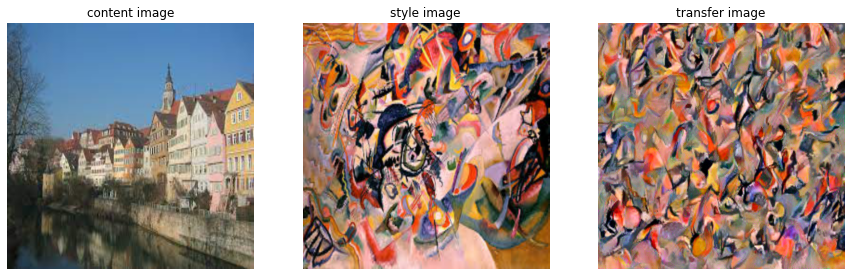

In [14]:
combine_img = torch.rand(content_img.shape).cuda()
content_layers = ['conv4_2',]
style_layers = ['conv1_1', 
                'conv1_2', 
                'conv2_1', 
                'conv3_1',
                'conv4_1',]

max_epoch = 3000
alpha = 1
beta = 100000000
style_weight = [0.2,0.2,0.2,0.2,0.2]

combine_img = LBFGS_style_transfer_train(model, features, combine_img,
                    content_features, style_features, content_layers, style_layers, 
                    learning_rate, max_epoch, alpha, beta, style_weight)
final_compare_show(content_img, style_img, combine_img)

#### seated-nude

In [34]:
style_image = Image.open('./style/seated-nude-femme-nue-assise-pablo-picasso-1909-f9095482.jpeg')
content_image = Image.open('./content/new_content.jpeg')
style_img = image_loader(style_image).cuda()
content_img = image_loader(content_image).cuda()
features = {}

model, content_features, style_features = content_style_features(layers_name, style_img, content_img, features)

Iteration: 1000, loss: 2.329064
Iteration: 2000, loss: 1.995173
Iteration: 3000, loss: 1.919658
Iteration: 4000, loss: 1.899615
Iteration: 5000, loss: 1.890860
Iteration: 6000, loss: 1.885832
Iteration: 7000, loss: 1.882262
Iteration: 8000, loss: 1.879385
Iteration: 9000, loss: 1.877021
Iteration: 10000, loss: 1.874969


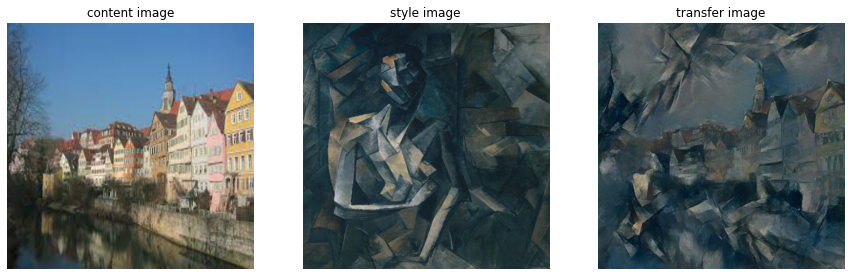

In [37]:
combine_img = torch.rand(content_img.shape).cuda()
content_layers = ['conv4_2',]
style_layers = ['conv1_1', 
                'conv2_1', 
                'conv3_1', 
                'conv4_1',
                'conv5_1',]

max_epoch = 10000
alpha = 1
beta = 500
style_weight = [0.2,0.2,0.2,0.2,0.2]

combine_img = LBFGS_style_transfer_train(model, features, combine_img,
                    content_features, style_features, content_layers, style_layers, 
                    learning_rate, max_epoch, alpha, beta, style_weight)
final_compare_show(content_img, style_img, combine_img)

Iteration: 1000, loss: 8.592779
Iteration: 2000, loss: 5.533342
Iteration: 3000, loss: 5.245672


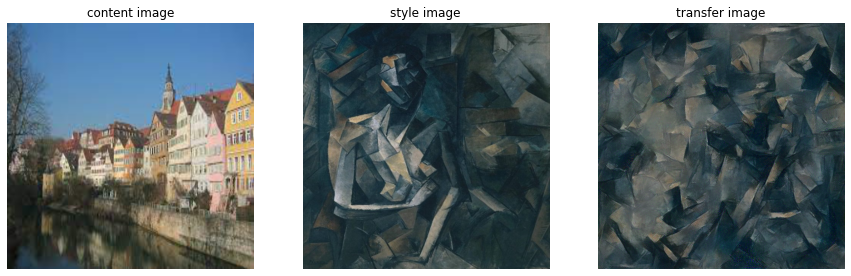

In [38]:
combine_img = torch.rand(content_img.shape).cuda()
content_layers = ['conv4_2',]
style_layers = ['conv1_1', 
                'conv2_1', 
                'conv3_1', 
                'conv4_1',
                'conv5_1',]

max_epoch = 3000
alpha = 1
beta = 10000
style_weight = [0.2,0.2,0.2,0.2,0.2]

combine_img = LBFGS_style_transfer_train(model, features, combine_img,
                    content_features, style_features, content_layers, style_layers, 
                    learning_rate, max_epoch, alpha, beta, style_weight)
final_compare_show(content_img, style_img, combine_img)

#### the shipwreck of the minotaur

In [39]:
style_image = Image.open('./style/the_shipwreck_of_the_minotaur.jpeg')
content_image = Image.open('./content/new_content.jpeg')
style_img = image_loader(style_image).cuda()
content_img = image_loader(content_image).cuda()
features = {}

model, content_features, style_features = content_style_features(layers_name, style_img, content_img, features)

Iteration: 1000, loss: 1.763670
Iteration: 2000, loss: 1.651822
Iteration: 3000, loss: 1.623581
Iteration: 4000, loss: 1.610636
Iteration: 5000, loss: 1.602686
Iteration: 6000, loss: 1.597508
Iteration: 7000, loss: 1.593725
Iteration: 8000, loss: 1.590745
Iteration: 9000, loss: 1.588299
Iteration: 10000, loss: 1.586312


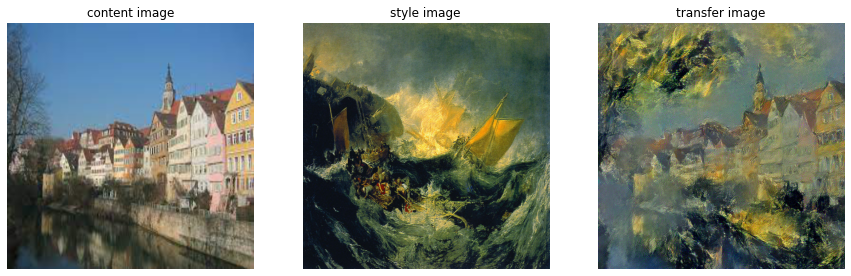

In [41]:
combine_img = torch.rand(content_img.shape).cuda()
content_layers = ['conv4_2',]
style_layers = ['conv1_1', 
                'conv2_1', 
                'conv3_1', 
                'conv4_1',
                'conv5_1',]

max_epoch = 10000
alpha = 1
beta = 125
style_weight = [0.2,0.2,0.2,0.2,0.2]

combine_img = LBFGS_style_transfer_train(model, features, combine_img,
                    content_features, style_features, content_layers, style_layers, 
                    learning_rate, max_epoch, alpha, beta, style_weight)
final_compare_show(content_img, style_img, combine_img)

Iteration: 1000, loss: 29158.181641
Iteration: 2000, loss: 16860.900391
Iteration: 3000, loss: 14310.074219


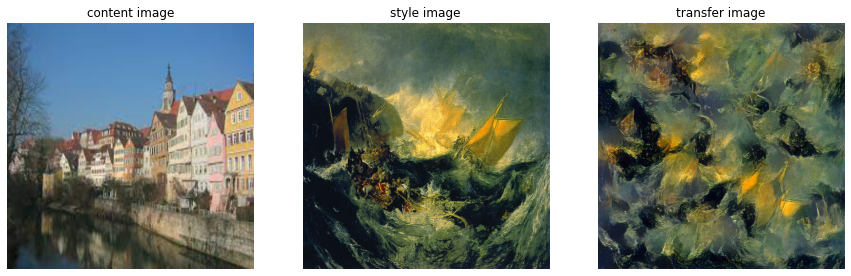

In [20]:
combine_img = torch.rand(content_img.shape).cuda()
content_layers = ['conv4_2',]
style_layers = ['conv1_1', 
                'conv2_1', 
                'conv3_1', 
                'conv4_1',
                'conv5_1',]

max_epoch = 3000
alpha = 1
beta = 10000
style_weight = [0.2,0.2,0.2,0.2,0.2]

combine_img = LBFGS_style_transfer_train(model, features, combine_img,
                    content_features, style_features, content_layers, style_layers, 
                    learning_rate, max_epoch, alpha, beta, style_weight)
final_compare_show(content_img, style_img, combine_img)

#### der schrei munch museum oslo

In [43]:
style_image = Image.open('./style/der-schrei-munch-museum-oslo.jpeg')
content_image = Image.open('./content/new_content.jpeg')
style_img = image_loader(style_image).cuda()
content_img = image_loader(content_image).cuda()
features = {}

model, content_features, style_features = content_style_features(layers_name, style_img, content_img, features)

Iteration: 1000, loss: 2.772209
Iteration: 2000, loss: 2.649153
Iteration: 3000, loss: 2.599066
Iteration: 4000, loss: 2.573465
Iteration: 5000, loss: 2.557657
Iteration: 6000, loss: 2.546441
Iteration: 7000, loss: 2.538154
Iteration: 8000, loss: 2.531919
Iteration: 9000, loss: 2.527022
Iteration: 10000, loss: 2.522814


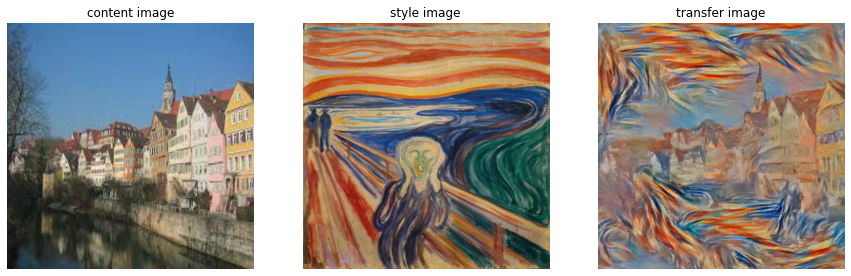

In [44]:
combine_img = torch.rand(content_img.shape).cuda()
content_layers = ['conv4_2',]
style_layers = ['conv1_1', 
                'conv2_1', 
                'conv3_1', 
                'conv4_1',
                'conv5_1',]

max_epoch = 10000
alpha = 1
beta = 125
style_weight = [0.2,0.2,0.2,0.2,0.2]

combine_img = LBFGS_style_transfer_train(model, features, combine_img,
                    content_features, style_features, content_layers, style_layers, 
                    learning_rate, max_epoch, alpha, beta, style_weight)
final_compare_show(content_img, style_img, combine_img)

Iteration: 1000, loss: 5.736376
Iteration: 2000, loss: 5.335574
Iteration: 3000, loss: 5.225751


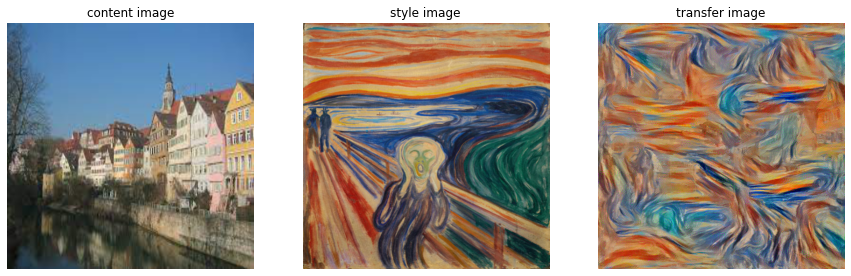

In [45]:
combine_img = torch.rand(content_img.shape).cuda()
content_layers = ['conv4_2',]
style_layers = ['conv1_1', 
                'conv2_1', 
                'conv3_1', 
                'conv4_1',
                'conv5_1',]

max_epoch = 3000
alpha = 1
beta = 1000
style_weight = [0.2,0.2,0.2,0.2,0.2]

combine_img = LBFGS_style_transfer_train(model, features, combine_img,
                    content_features, style_features, content_layers, style_layers, 
                    learning_rate, max_epoch, alpha, beta, style_weight)
final_compare_show(content_img, style_img, combine_img)

### complexity

In [46]:
style_image = Image.open('./style/the_shipwreck_of_the_minotaur.jpeg')
content_image = Image.open('./content/duke_flag.jpeg')
style_img = image_loader(style_image).cuda()
content_img = image_loader(content_image).cuda()
features = {}

model, content_features, style_features = content_style_features(layers_name, style_img, content_img, features)

Iteration: 1000, loss: 2.702524
Iteration: 2000, loss: 2.587514
Iteration: 3000, loss: 2.543401
Iteration: 4000, loss: 2.521927
Iteration: 5000, loss: 2.509900
Iteration: 6000, loss: 2.502180
Iteration: 7000, loss: 2.496612
Iteration: 8000, loss: 2.492236
Iteration: 9000, loss: 2.488693
Iteration: 10000, loss: 2.485810


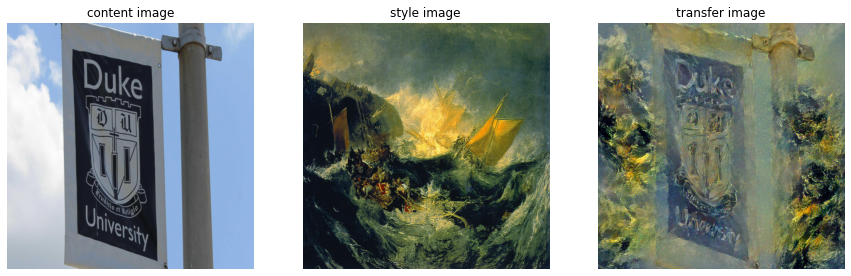

In [47]:
combine_img = torch.rand(content_img.shape).cuda()
content_layers = ['conv4_2',]
style_layers = ['conv1_1', 
                'conv2_1', 
                'conv3_1', 
                'conv4_1',
                'conv5_1',]

max_epoch = 10000
alpha = 1
beta = 125
style_weight = [0.2,0.2,0.2,0.2,0.2]

combine_img = LBFGS_style_transfer_train(model, features, combine_img,
                    content_features, style_features, content_layers, style_layers, 
                    learning_rate, max_epoch, alpha, beta, style_weight)
final_compare_show(content_img, style_img, combine_img)

In [48]:
style_image = Image.open('./style/starry_night.jpeg')
content_image = Image.open('./content/duke_flag.jpeg')
style_img = image_loader(style_image).cuda()
content_img = image_loader(content_image).cuda()
features = {}

model, content_features, style_features = content_style_features(layers_name, style_img, content_img, features)

Iteration: 1000, loss: 3.977167
Iteration: 2000, loss: 3.876052
Iteration: 3000, loss: 3.834789
Iteration: 4000, loss: 3.811765
Iteration: 5000, loss: 3.797146
Iteration: 6000, loss: 3.786945
Iteration: 7000, loss: 3.779623
Iteration: 8000, loss: 3.773686
Iteration: 9000, loss: 3.768834
Iteration: 10000, loss: 3.764789


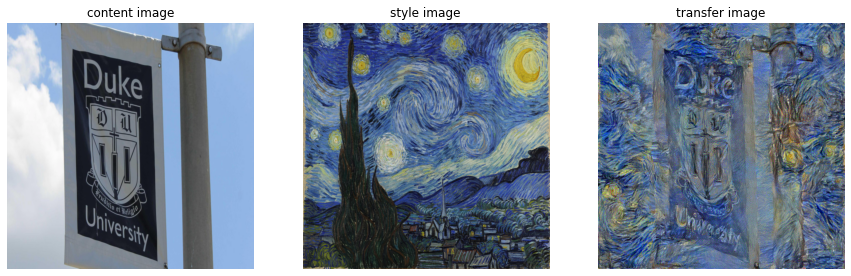

In [50]:
combine_img = torch.rand(content_img.shape).cuda()
content_layers = ['conv4_2',]
style_layers = ['conv1_1', 
                'conv2_1', 
                'conv3_1', 
                'conv4_1',
                'conv5_1',]

max_epoch = 10000
alpha = 1
beta = 125
style_weight = [0.2,0.2,0.2,0.2,0.2]

combine_img = LBFGS_style_transfer_train(model, features, combine_img,
                    content_features, style_features, content_layers, style_layers, 
                    learning_rate, max_epoch, alpha, beta, style_weight)
final_compare_show(content_img, style_img, combine_img)

In [51]:
style_image = Image.open('./style/der-schrei-munch-museum-oslo.jpeg')
content_image = Image.open('./content/duke_flag.jpeg')
style_img = image_loader(style_image).cuda()
content_img = image_loader(content_image).cuda()
features = {}

model, content_features, style_features = content_style_features(layers_name, style_img, content_img, features)

Iteration: 1000, loss: 3.627561
Iteration: 2000, loss: 3.502476
Iteration: 3000, loss: 3.455005
Iteration: 4000, loss: 3.426652
Iteration: 5000, loss: 3.408386
Iteration: 6000, loss: 3.395723
Iteration: 7000, loss: 3.385975
Iteration: 8000, loss: 3.377954
Iteration: 9000, loss: 3.371182
Iteration: 10000, loss: 3.365500


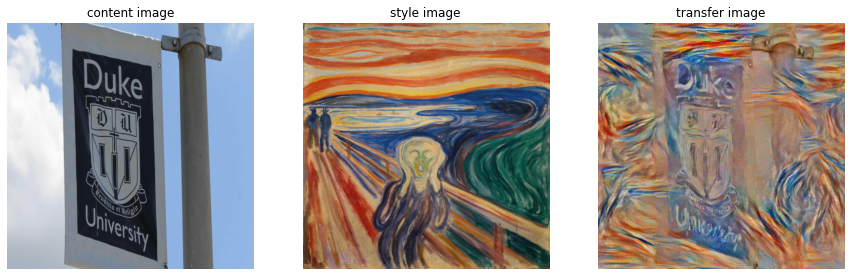

In [52]:
combine_img = torch.rand(content_img.shape).cuda()
content_layers = ['conv4_2',]
style_layers = ['conv1_1', 
                'conv2_1', 
                'conv3_1', 
                'conv4_1',
                'conv5_1',]

max_epoch = 10000
alpha = 1
beta = 125
style_weight = [0.2,0.2,0.2,0.2,0.2]

combine_img = LBFGS_style_transfer_train(model, features, combine_img,
                    content_features, style_features, content_layers, style_layers, 
                    learning_rate, max_epoch, alpha, beta, style_weight)
final_compare_show(content_img, style_img, combine_img)

### Different Layers

In [54]:
style_image = Image.open('./style/starry_night.jpeg')
content_image = Image.open('./content/new_content.jpeg')
style_img = image_loader(style_image).cuda()
content_img = image_loader(content_image).cuda()
features = {}

model, content_features, style_features = content_style_features(layers_name, style_img, content_img, features)

Iteration: 1000, loss: 5.231398
Iteration: 2000, loss: 4.622239
Iteration: 3000, loss: 4.482422
Iteration: 4000, loss: 4.433834
Iteration: 5000, loss: 4.410444
Iteration: 6000, loss: 4.396931
Iteration: 7000, loss: 4.388201
Iteration: 8000, loss: 4.382038
Iteration: 9000, loss: 4.377072
Iteration: 10000, loss: 4.373273


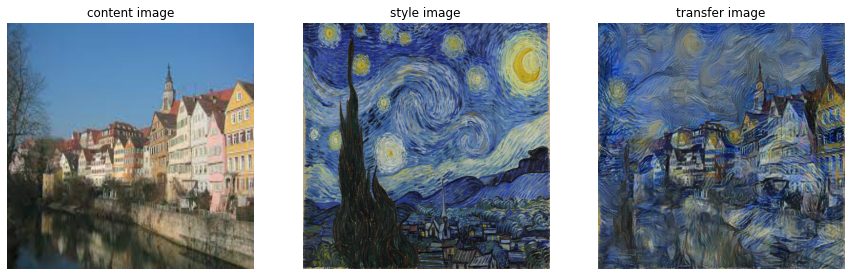

In [58]:
combine_img = torch.rand(content_img.shape).cuda()
content_layers = ['conv2_2',]
style_layers = ['conv1_1', 
                'conv2_1', 
                'conv3_1', 
                'conv4_1',
                'conv5_1',]

max_epoch = 10000
alpha = 1
beta = 1000
style_weight = [0.2,0.2,0.2,0.2,0.2]

combine_img = LBFGS_style_transfer_train(model, features, combine_img,
                    content_features, style_features, content_layers, style_layers, 
                    learning_rate, max_epoch, alpha, beta, style_weight)
final_compare_show(content_img, style_img, combine_img)

In [32]:
style_image = Image.open('./style/starry_night.jpeg')
content_image = Image.open('./content/new_content.jpeg')
style_img = image_loader(style_image).cuda()
content_img = image_loader(content_image).cuda()
features = {}

model, content_features, style_features = content_style_features(layers_name, style_img, content_img, features)

Iteration: 1000, loss: 8.762079
Iteration: 2000, loss: 8.055754
Iteration: 3000, loss: 7.888465
Iteration: 4000, loss: 7.829197
Iteration: 5000, loss: 7.797872
Iteration: 6000, loss: 7.778293
Iteration: 7000, loss: 7.764471
Iteration: 8000, loss: 7.754303
Iteration: 9000, loss: 7.745930
Iteration: 10000, loss: 7.739076


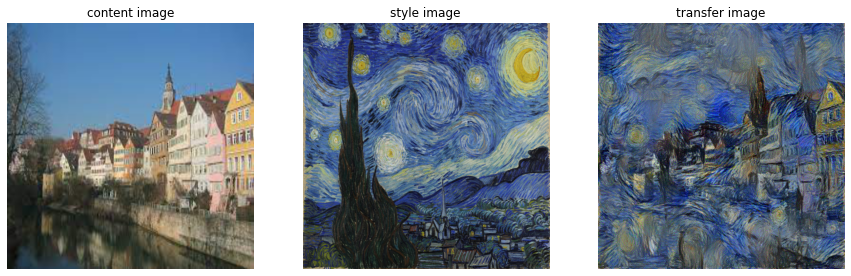

In [57]:
combine_img = torch.rand(content_img.shape).cuda()
content_layers = ['conv3_2',]
style_layers = ['conv1_1', 
                'conv2_1', 
                'conv3_1', 
                'conv4_1',
                'conv5_1',]

max_epoch = 10000
alpha = 1
beta = 1000
style_weight = [0.2,0.2,0.2,0.2,0.2]

combine_img = LBFGS_style_transfer_train(model, features, combine_img,
                    content_features, style_features, content_layers, style_layers, 
                    learning_rate, max_epoch, alpha, beta, style_weight)
final_compare_show(content_img, style_img, combine_img)

Iteration: 1000, loss: 55020.128906
Iteration: 2000, loss: 47374.417969
Iteration: 3000, loss: 44765.515625
Iteration: 4000, loss: 43556.320312
Iteration: 5000, loss: 42893.570312
Iteration: 6000, loss: 42472.878906
Iteration: 7000, loss: 42182.898438
Iteration: 8000, loss: 41965.363281
Iteration: 9000, loss: 41792.921875
Iteration: 10000, loss: 41654.671875


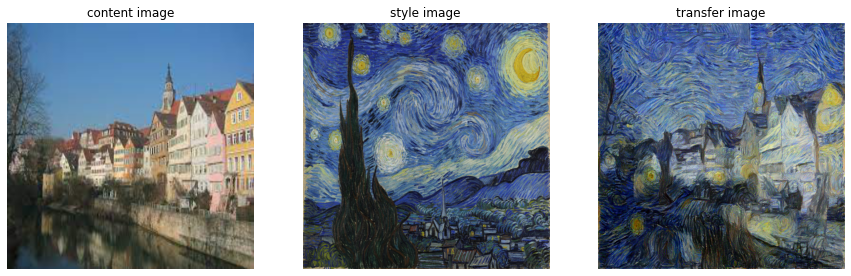

In [55]:
combine_img = image_loader(content_image).cuda()
content_layers = ['conv4_2',]
style_layers = ['conv1_1', 
                'conv2_1', 
                'conv3_1', 
                'conv4_1',
                'conv5_1',]

learning_rate = 0.05
max_epoch = 10000
alpha = 1
beta = 100000000
style_weight = [0.2,0.2,0.2,0.2,0.2]

combine_img = LBFGS_style_transfer_train(model, features, combine_img,
                    content_features, style_features, content_layers, style_layers, 
                    learning_rate, max_epoch, alpha, beta, style_weight)
final_compare_show(content_img, style_img, combine_img)